# Yandex Cup ML Challenge 2023: RecSys

[Ссылка на контест](https://contest.yandex.ru/contest/54251/problems/)

## A. В поисках реальности

### Формат ввода
Данные можно скачать по ссылкам:
- https://disk.yandex.ru/d/Q9gnaU4HvL5nyQ — данные для обучения; 
- https://disk.yandex.ru/d/_fitwckjDkCIPA — архив с ембедингами треков.

Также данные доступны на Kaggle: https://www.kaggle.com/datasets/sharthz23/yandex-cup-2023-recsys

В первом архиве `data.tar.gz` 4 файла:

- `train.csv` — содержит трек ид и список тегов в через запятую, всего тегов 256;
- `test.tsv` — такой же формат но без списка тегов;
- `Baseline.ipynb` — пример ноутбука с наивной моделью;
- `sample_submission.csv` — пример решения.

Во втором архиве `track_embeddings.tar.gz` содержатся файлы с ембедингами треков. `dtype = np.float32` читать можно через `numpy.load`. Размерность ембедингов 768. Каждый файл содержит в названии ид соответствующего трека.

### Формат вывода
В качестве решения необходимо отправить файл в формате `csv` с двумя колонками `track` и `prediction` для каждого трека из `test.csv` в том же порядке. В колонке `prediction` нужно записать вероятности тегов через запятую в виде строки.

### Примечания
В качестве метрики используется [Average precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Ограничение на загружаемый файл - 250мб. Предупреждаем, что решение может долго загружаться.


## Подготовка

При локальном запуске измените пути до файлов в следующей ячейке с кодом

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

train_data = 'train.csv'
test_data = 'test.csv'
sample = 'sample_submission.csv'

# Hide GPU from TensorFlow
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

embeddings_path = os.path.join('/tf','shared_data','embeddings') + os.path.sep
n_tags = 256

In [2]:
train_csv = pd.read_csv(train_data)
test_csv = pd.read_csv(test_data)
train_csv

,track,tags
0,49734,"5,6,9,26,32,55,96"
1,67845,"6,9,28,39,145,155"
2,25302,"0,6,28,40,116,168"
3,57796,"28,186"
4,13676,"6,23,177"
...,...,...
51129,1858,"1,11,12,15,37,74,245"
51130,53319,"1,23,35,131,180,244"
51131,52102,"5,23,89,127"
51132,66401,"0,111,235"


In [3]:
def one_hot(tags):
    vector = np.zeros(n_tags, dtype='bool')
    vector[[int(i) for i in tags.split(',')]] = 1
    return vector

train_tags = pd.DataFrame(train_csv['tags'].apply(one_hot).tolist())
train_csv = pd.concat([train_csv, train_tags], axis=1).drop('tags', axis=1)
train_csv

,track,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,49734,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,67845,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,25302,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,57796,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,13676,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51129,1858,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
51130,53319,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
51131,52102,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
51132,66401,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
from glob import glob

cnt_ids = len(test_csv.index) + len(train_csv.index)
cnt_ids, len(glob(embeddings_path + '*'))

(76714, 76714)

In [5]:
from re import fullmatch

is_present = np.full(cnt_ids, False, 'bool')
regex = embeddings_path + r'(\d{,5}).npy'

for file in glob(embeddings_path + '*'):
    part = fullmatch(regex, file)
    if not part:
        print(file)
        continue
    is_present[int(part[1])] = True

np.alltrue(is_present)

True

In [6]:
embeddings0 = np.load(embeddings_path + '0.npy')
embeddings0.shape, embeddings0.dtype

((131, 768), dtype('float32'))

In [7]:
dims = np.zeros(cnt_ids, 'int32')

for i in range(cnt_ids):
    path = embeddings_path + str(i) + '.npy'
    emb = np.load(path)
    assert(emb.ndim == 2 and emb.shape[1] == 768)
    dims[i] = emb.shape[0]

(10, 404)

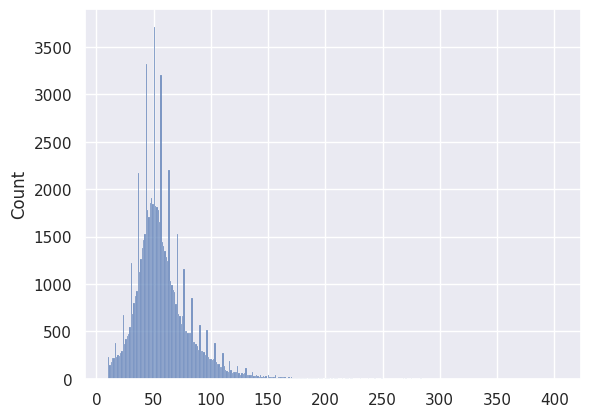

In [8]:
sns.histplot(dims)
np.min(dims), np.max(dims)

In [9]:
np.mean(dims), np.std(dims)

(58.04167427066768, 26.334504678369505)

In [10]:
bytes = 0

for file in os.listdir(embeddings_path):
    bytes += os.path.getsize(os.path.join(embeddings_path, file))

print('Total embeddings memory is {:.2f} GiB'.format(bytes / (1 << 30)))

Total embeddings memory is 12.75 GiB


## Достаем серьезные игрушки

In [11]:
import tensorflow as tf

# tf.debugging.set_log_device_placement(True)

2023-10-26 21:50:42.540699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-26 21:50:42.540722: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-26 21:50:42.540740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 21:50:42.545182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
max_len = 150
emb_len = 768

def generate_train_data():
    file_format = embeddings_path + '{}.npy'
    labels = train_csv[[*range(n_tags)]].astype('float32')
    
    for (i, track) in train_csv.track.items():
        inputs = np.zeros(shape=(max_len, emb_len), dtype='float32')
        
        track_path = file_format.format(track)
        emb = np.load(track_path)
        
        ln = min(max_len, emb.shape[0])
        inputs[-ln:, :] = emb[-ln:, :]
        
        yield (inputs, labels.iloc[i])

In [13]:
def prep_tagged_data():
    return tf.data.Dataset.from_generator(
        generate_train_data, 
        output_signature=(
            tf.TensorSpec(shape=(max_len, emb_len), dtype=tf.float32), 
            tf.TensorSpec(shape=(n_tags), dtype=tf.float32)
        )
    )

In [14]:
def plot_train_losses(history):
    plt.plot(history.epoch, history.history['binary_crossentropy'], label='BCE Train')
    plt.plot(history.epoch, history.history['val_binary_crossentropy'], '--', label='BCE Validation')
    # plt.plot(history.epoch, history.history['loss'], label='BCE+L2 Train')
    # plt.plot(history.epoch, history.history['val_loss'], '--', label='BCE+L2 Validation')
    plt.plot(history.epoch, history.history['prc'], label='AUC (PR) Train')
    plt.plot(history.epoch, history.history['val_prc'], '--', label='AUC (PR) Validation')
    
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()

### TF Model Gallery

- GRU-Unit Recurrent and Wide model
- Deep Linear layers and Double-GRU layered model
- same model with L2 regularization
- Parallel MaskNet feature extraction feeding RNN


In [15]:
from tensorflow.keras import Sequential, layers, regularizers


def prep_rnn_model():
    rnn_sz = 256
    hidden_sz = 32 * n_tags
    
    rnn_model = Sequential()
    rnn_model.add(layers.InputLayer(input_shape=(max_len, emb_len,)))

    rnn_model.add(layers.LayerNormalization())
    rnn_model.add(layers.GRU(rnn_sz))

    # Council will decide your Fate
    rnn_model.add(layers.Dense(hidden_sz, activation='relu'))
    rnn_model.add(layers.Dropout(0.5))
    
    rnn_model.add(layers.Dense(n_tags))
    
    rnn_model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['binary_accuracy', 
                 tf.keras.metrics.BinaryCrossentropy(from_logits=True),
                 tf.keras.metrics.AUC(name='prc', curve='PR')]
    )
    # Evaluation: tf.keras.activation.sigmoid(model(test_ds))
    
    return rnn_model

In [16]:
from tensorflow.keras import Sequential, layers, regularizers


def prep_rnn_model_dense():
    rnn_sz = 256
    hidden_sz = 5 * n_tags
    
    rnn_model = Sequential()
    rnn_model.add(layers.InputLayer(input_shape=(max_len, emb_len,)))

    rnn_model.add(layers.LayerNormalization())
    rnn_model.add(layers.Dense(emb_len, activation='relu'))
    rnn_model.add(layers.Dense(emb_len // 2))

    rnn_model.add(layers.LayerNormalization())
    rnn_model.add(layers.GRU(rnn_sz, return_sequences=True))
    rnn_model.add(layers.GRU(rnn_sz))

    rnn_model.add(layers.Dense(hidden_sz, activation='relu'))
    rnn_model.add(layers.Dropout(0.5))
    
    rnn_model.add(layers.Dense(n_tags))
    
    rnn_model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['binary_accuracy', 
                 tf.keras.metrics.BinaryCrossentropy(from_logits=True),
                 tf.keras.metrics.AUC(name='prc', curve='PR')]
    )
    # Evaluation: tf.keras.activation.sigmoid(model(test_ds))
    
    return rnn_model

In [17]:
from tensorflow.keras import Sequential, layers


class MaskBlock(layers.Layer):
    def __init__(self, output_size, reduction_factor=1.0):
        super().__init__()
        self.input_norm = layers.LayerNormalization()
        self.layer_norm = layers.LayerNormalization()
        
        self.reduction_factor = reduction_factor
        self.output_size = output_size
        self.mlp = layers.Dense(output_size)

        

    def build(self, input_shape):
        mask_size = input_shape[-1]
        units = int(mask_size * self.reduction_factor)

        self.mask_layer = Sequential([
            layers.Dense(units, activation='relu'),
            layers.Dense(mask_size)
        ])
        

    def call(self, inputs):
        net = self.input_norm(inputs)
        mask = self.mask_layer(inputs)

        output = self.mlp(net * mask)
        
        return self.layer_norm(output)

    def get_config(self):
        return { "reduction_factor": self.reduction_factor, "output_size": self.output_size }


def prep_mask_net():
    rnn_sz = 512
    hidden_sz = 32 * n_tags
    mask_blocks = 5
    
    inputs = tf.keras.Input(shape=(max_len, emb_len,))

    x = layers.concatenate([MaskBlock(emb_len)(inputs) for _ in range(mask_blocks)])

    x = layers.GRU(rnn_sz, return_sequences=True)(x)
    x = layers.GRU(rnn_sz)(x)

    x = layers.LayerNormalization()(x)

    x = layers.Dense(hidden_sz, activation='relu')(x)
    outputs = layers.Dense(n_tags)(x)

    masking_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MaskNet')

    masking_model.compile(
        optimizer='adam', 
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['binary_accuracy', 
                 tf.keras.metrics.BinaryCrossentropy(from_logits=True),
                 tf.keras.metrics.AUC(name='prc', curve='PR')]
    )
    # Evaluation: tf.keras.activation.sigmoid(model(test_ds))
    
    return masking_model

In [18]:
from tensorflow.keras.utils import plot_model

model = prep_mask_net()
plot_model(model, 'wider_masknet.png', show_shapes=True)

print(model.input_shape)
model.summary()

2023-10-26 21:50:43.816063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-26 21:50:43.819149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-26 21:50:43.819278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 150, 768)
Model: "MaskNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 768)]           0         []                            
                                                                                                  
 mask_block (MaskBlock)      (None, 150, 768)             1774848   ['input_1[0][0]']             
                                                                                                  
 mask_block_1 (MaskBlock)    (None, 150, 768)             1774848   ['input_1[0][0]']             
                                                                                                  
 mask_block_2 (MaskBlock)    (None, 150, 768)             1774848   ['input_1[0][0]']             
                                                                           

In [19]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

ds = prep_tagged_data()

VAL_SIZE = len(train_csv.index) // 10
train_ds = ds.skip(VAL_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds.take(VAL_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


model_callbacks = [
    EarlyStopping(patience=5),
    TensorBoard(log_dir='dnn/logs'),
    ModelCheckpoint('dnn/best', monitor='val_prc', save_best_only=True, mode='max')
]

In [21]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=model_callbacks)

2023-10-26 21:50:54.188659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-26 21:50:55.216627: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb78564bb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-26 21:50:55.216646: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-26 21:50:55.220108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-26 21:50:55.317008: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1439/Unknown - 285s 191ms/step - loss: 0.0589 - binary_accuracy: 0.9859 - binary_crossentropy: 0.0589 - prc: 0.1357

2023-10-26 21:55:46.360650: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9434552737276029176


INFO:tensorflow:Assets written to: dnn/best/assets


INFO:tensorflow:Assets written to: dnn/best/assets


1439/1439 [==============================] - 309s 207ms/step - loss: 0.0589 - binary_accuracy: 0.9859 - binary_crossentropy: 0.0589 - prc: 0.1357 - val_loss: 0.0524 - val_binary_accuracy: 0.9865 - val_binary_crossentropy: 0.0524 - val_prc: 0.1798


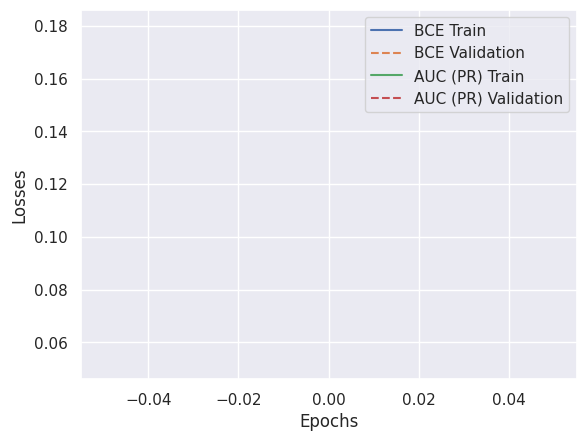

In [22]:
plot_train_losses(hist)

In [23]:
model = tf.keras.models.load_model('dnn/best')

In [24]:
def generate_test_data():
    file_format = embeddings_path + '{}.npy'
    
    for (i, track) in test_csv.track.items():
        inputs = np.zeros(shape=(max_len, emb_len), dtype='float32')
        
        track_path = file_format.format(track)
        emb = np.load(track_path)
        
        ln = min(max_len, emb.shape[0])
        inputs[-ln:, :] = emb[-ln:, :]
        
        yield inputs

def prep_test_data():
    return tf.data.Dataset.from_generator(
        generate_test_data, 
        output_signature=tf.TensorSpec(shape=(max_len, emb_len), dtype=tf.float32)
    )

test_ds = prep_test_data().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_outputs = tf.keras.activations.sigmoid(model.predict(test_ds))

probs = tf.strings.as_string(test_outputs, precision=6)
probs = tf.strings.join(tf.transpose(probs), ',')

800/800 [==============================] - 74s 92ms/step


2023-10-26 21:57:12.224396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26193920 exceeds 10% of free system memory.
2023-10-26 21:57:12.306120: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26193920 exceeds 10% of free system memory.
2023-10-26 21:57:12.308828: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157163520 exceeds 10% of free system memory.
2023-10-26 21:57:13.806057: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157163520 exceeds 10% of free system memory.


In [25]:
test_csv['prediction'] = probs.numpy()
test_csv.prediction = test_csv.prediction.str.decode('utf-8')
test_csv

,track,prediction
0,17730,"0.114267,0.108182,0.074099,0.345046,0.014251,0..."
1,32460,"0.200583,0.287717,0.430132,0.201906,0.038965,0..."
2,11288,"0.064538,0.277490,0.196500,0.078998,0.005038,0..."
3,18523,"0.330332,0.223013,0.570433,0.103014,0.056870,0..."
4,71342,"0.032932,0.034009,0.047047,0.175852,0.001401,0..."
...,...,...
25575,40192,"0.053463,0.866453,0.340633,0.026912,0.009545,0..."
25576,4481,"0.849225,0.131959,0.127108,0.022253,0.152789,0..."
25577,5257,"0.056743,0.029834,0.032250,0.261479,0.003539,0..."
25578,73095,"0.996579,0.008217,0.003669,0.004409,0.037762,0..."


In [26]:
test_csv.to_csv('submission_masking.csv', index=False)

#### Simple RNN with wide MLP `0.1984652647678659`

![GRU cells](wide_rnn.png)

#### Stacked RNN with MLP feature extraction `0.20544854465898205`

![dense feature extraction](feat_dense.png)

#### Parallel MaskNet `0.19802501373063325`

![MaskNet for feature extraction](mask_net.png)